# Преобработка данных под сверточную нейронную сеть

Подключение нужных инструментов

In [6]:
# основные библиотеки
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# ML библиотеки
from sklearn.model_selection import train_test_split
import cv2
# библиотека для обработки аудио
import librosa
import librosa.display
import IPython.display as ipd
# дополнительные инструменты
from tqdm import tqdm
import pylab
from random import random, randrange
import random

# Описание 
#### Использовалась знаменитая коллекция музыкальных жанров GTZAN - http://marsyas.info/downloads/datasets.html
- 1000 звуковых дорожек
- 10 жанров по 100 треков
- 30 секунд каждая
- моно, 16 бит
- формат: WAV
- от качественных записей до старинных записей с микрофона

In [7]:
# папки, представленные в датасете
DIRS = os.listdir('./data/')
for DIR in DIRS:
    print(DIR)

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


#### Случайный фрагмент из датасета

In [8]:
def random_file(path):
    """
    Принимает на вход файловый путь
    Возвращает случайный файл/папку в виде строки из данного файлового пути
    """
    files_amount = len(os.listdir(path)) - 1
    idx = np.random.randint(files_amount)
    return path + '/' + os.listdir(path)[idx]
def get_random_wav_path():
    """
    Возвращает путь к случайному треку из датасета в виде строки
    """
    random_genre = random_file('./data')
    return random_file(random_genre)

random_wav = get_random_wav_path()
print('Случайный трек: ' + random_wav)
audio, sr = librosa.load(random_wav, dtype=np.float32)
audio_length = audio.shape[0] / sr
print('Длительность дорожки: ', int(audio_length), 'сек')
starting_point = round(np.random.uniform(audio_length - 10))
x = audio[starting_point*sr:(starting_point+10)*sr]
ipd.Audio(data=x, rate=sr)

Случайный трек: ./data/hiphop/hiphop.00037.wav
Длительность дорожки:  30 сек


#### Визуализация звуковых дорожек разных жанров, можно увидеть, что они сильно отличаются в представлении волновых диаграмм

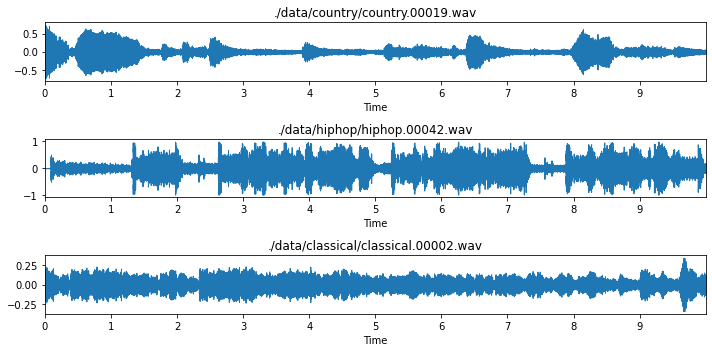

In [62]:
fig = plt.figure(figsize=(10, 5))
for i in range(1, 4):
    random_wav = get_random_wav_path()
    ax = fig.add_subplot(3, 1, i)
    y, sr = librosa.load(random_wav)  
    librosa.display.waveplot(y[:10*sr], sr)
    plt.title(random_wav)
fig.tight_layout()

### Представление аудиоинформации в виде mel-спектрограммы для использования в сверточной НС
Mel-спектрограммы - это представление в виде изображения зависимости частоты звукового сигнала от времени, где дополнительная шкала (градиент) - сила звука в децибеллах

In [13]:
def read_wav_file(path, preprocess=True):
    """
    Читает wav файл и нарезает его на 3 по 10 секунд дорожки
    
    path: путь к файлу
    preprocess: применяет к сигналу формулу: y(t) = x(t) − α ∗ x(t−1);
    где α устанвливается как 0.97 для выделения высоких частот
    формула взята на основе биологических особенностей восприятия звука человеческим ухом
    
    Возвращает: список сигналов в виде np.arrays и частоту дискретизации в виде целого
    """
    y, sr = librosa.load(path)
    if preprocess:
        x = y.copy()
        z = y[1:] - 0.97 * x[:-1]
        y = z
        
    signals = []
    for signal_id in range(3):
        signals.append(z[signal_id*sr*10:(signal_id+1)*sr*10])
    return signals, sr


def create_spectrogram(z, sr, save_path):
    """
    Строит спектрограмму с частотой дискретизации sr 
    и сохраняет ее по пути save_path
    """
    pylab.axis('off')
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    S = librosa.feature.melspectrogram(y=z, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
    pylab.close()
    
    
def resize_image(path):
    """
    Изменяет размер изображения, которая хранится по пути path на 224х224 для получения удобной матрицы на вход НС
    """
    SIZE = 224, 224
    im = Image.open(path)
    resized_im = im.resize(SIZE)
    resized_im.save(path)

def full_preprocess(path, save_path):
    """
    Полностью обрабатывает одну аудиодорожку, находящуюся по пути path
    и сохраняет ее в виде трех спектрограмм 224х224 по пути save_path
    """
    y, sr = read_wav_file(path)
    idx = 0
    for signal_id in y:
        save_to = save_path + '_' + str(idx) + '.jpg'
        create_spectrogram(signal_id, sr, save_to)
        resize_image(save_to)
        idx += 1
        
def prepare_dataset(path='./', test_size=0.2):
    """
    Обрабатывает все аудиодорожки в папке path/data/
    и сохраняет все спектрограммы в папки 'test' и 'train' в соотношении test_size/(1 - test_size)
    """
    folders = ('train', 'test')
    for folder in folders:
        if folder not in os.listdir():
            os.mkdir('./' + folder)
    
    genres = os.listdir(path + '/data')
    for genre in genres:
        for folder in folders:
            if genre not in ('./' + folder):
                os.mkdir('./' + folder + '/' + genre)
        audios = os.listdir(path + '/data/' + genre)
        audios_amount = len(audios)
        id_audio = 0
        for id_audio in tqdm(range(audios_amount)):
            if id_audio < int(test_size * audios_amount):
                folder = './test/'
            else:
                folder = './train/'
            full_preprocess(path + '/data/' + genre + '/' + audios[id_audio], \
                           folder + genre + '/' + audios[id_audio][:-4])

### Обработка каждой папки (каждого жанра) в датасете
Процесс обработки аудио и их сохранение в виде mel-спектрограмм

In [15]:
prepare_dataset()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.87it/s]


#### Результат обработки 

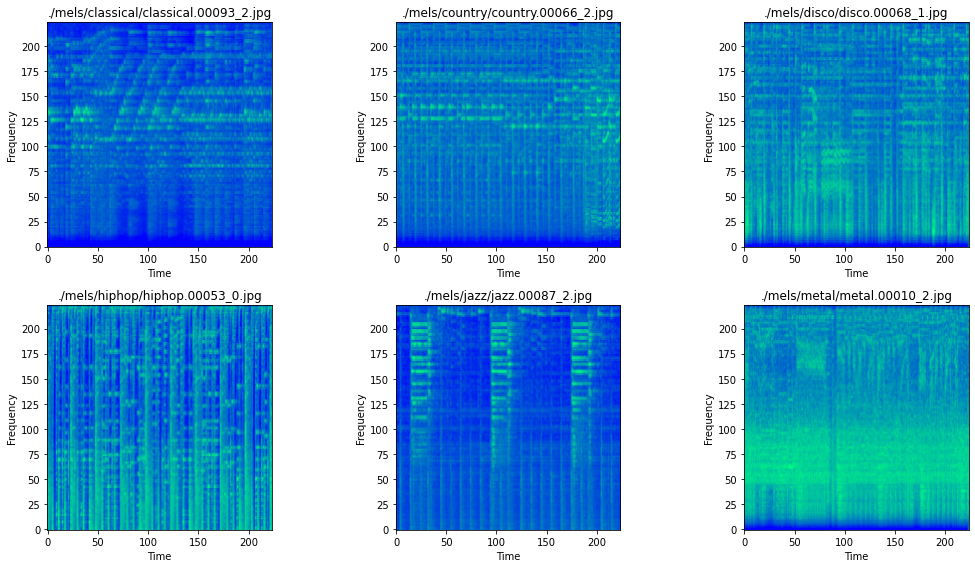

In [21]:
fig = plt.figure(figsize=(15, 8))
for i in range(1, 7):
    genre = './mels/' + DIRS[i]
    random_mel = random_file(genre), genre[7:]
    ax = fig.add_subplot(2, 3, i)
    im = cv2.imread(random_mel[0], cv2.IMREAD_GRAYSCALE)
    plt.title(random_mel[0])
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.imshow(im, cmap='winter', aspect='equal', origin="lower")
fig.tight_layout()

### Полностью подготовленные мел-спектрограммы используются как входные данные в сверточную нейронную сеть, которую быстрее обучать в сервисе google.colaboratory, используя ресурсы гугл, поэтому проектирование и обучение НС описано в файле CNN_Pytorch.ipynb
Загрузить датасет аудио сразу на гугл диск и обрабатывать (подгружать каждый файл в гугл колаб) его в одном файле не эффективно из-за его размеров (около 4 Гб), а при локальной обработке получился датасет изображений всего на 50 Мб, который с легкостью загружается и быстро выгружается на/с гугл диска

# Загрузка изображений на гугл диск

In [25]:
from google.oauth2 import service_account
from googleapiclient.http import MediaIoBaseDownload,MediaFileUpload
from googleapiclient.discovery import build
import pprint

#### Настройка ключей сервисного аккаунта гугл и определение его роли 

In [29]:
SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = './cnnproject-317007-739854b06f9c.json'

In [30]:
credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('drive', 'v3', credentials=credentials)

#### Проверка правильного подкючения аккаунта и определение id папки Colab Notebooks

In [61]:
results = service.files().list(pageSize=10,
                               fields="nextPageToken, files(id, name)").execute()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)

{   'files': [   {   'id': '1sXiqbmGzkCJgK7p-1Rioat0yRN5n-hiE',
                     'name': 'metal.00027_1.jpg'},
                 {   'id': '1NIZA_CtRquLLfCgN93TYrE9Tffny2flx',
                     'name': 'metal.00027_0.jpg'},
                 {   'id': '1BrIeg7hcoj-386ZAkF41kADL03U9yGzA',
                     'name': 'metal.00026_2.jpg'},
                 {   'id': '1fxcNVZ4Mwfj1FQCiJqhL9fS2mEegWufG',
                     'name': 'metal.00026_1.jpg'},
                 {   'id': '1TdQ8l1vKQuIsTUKEMs49CA9KA4xYaLb8',
                     'name': 'metal.00026_0.jpg'},
                 {   'id': '1uMkUxUzqXVKTnXR4VEavbWaovRDLoiJI',
                     'name': 'metal.00025_2.jpg'},
                 {   'id': '1MwVVgtYIo3iiZP2Xy9HQK5La8RQwELO-',
                     'name': 'metal.00025_1.jpg'},
                 {   'id': '1XToee8_H1nxstS8E4bIaBwmmyXAInyds',
                     'name': 'metal.00025_0.jpg'},
                 {   'id': '1enicut4x-XpwJG9o7Jq0o-qp5nj9uh4l',
                

In [54]:
google_folder_id = '1ahZxcSKqVIHQffgfmD7Zjy14FAawWeKD'

### Выгрузка датасета на гугл диск

In [69]:
def create_new_folder(new_folder_name, folder_id):
    """
    Создает новую папку на гугл диске
    new_folder_name: имя новой папки
    folder_id: id папки на гугл диске в которой нужно создать папку
    Возвращает id созданной папки
    """
    name = new_folder_name
    file_metadata = {
        'name': name,
        'mimeType': 'application/vnd.google-apps.folder',
        'parents': [folder_id]
    }
    r = service.files().create(body=file_metadata,
                                        fields='id').execute()
    return r['id']

def upload_folder_to_google_drive(folder_name, google_folder_id):
    """
    Загружает папку с mel-датасетом на гугл диск
    folder_name: путь к папке на компьютере
    google_folder_id: id гугл папки в которую загружаем
    """
    created_folder_id = create_new_folder(folder_name, google_folder_id)
    genres = os.listdir('./' + folder_name)
    for genre in genres:
        genre_folder_id = create_new_folder(genre, created_folder_id)
        files = os.listdir('./' + folder_name + '/' + genre)
        for file in tqdm(files):
            name = file
            file_path = './' + folder_name + '/' + genre + '/' + file
            file_metadata = {
                'name': name,
                'parents': [genre_folder_id]
            }
            media = MediaFileUpload(file_path, resumable=True)
            r = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

In [71]:
upload_folder_to_google_drive('test', google_folder_id)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:23<00:00,  1.39s/it]


In [ ]:
upload_folder_to_google_drive('train', google_folder_id)

На выгрузку всего датасета, уменьшенного после обработки данных в __80!__ раз (аудиодорожки - 4 Гб | изображения - 50 Мб),
потребовалось около __одного часа__

# Продолжение в файле CNN_PyTorch.ipynb